# Wines Points prediction 

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [2]:
import pandas as pd
import cufflinks as cf; cf.go_offline()

In [3]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_reviews.shape

(129971, 14)

In [4]:
wine_reviews.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
80527,80527,Italy,"Sunbaked earth, mature black-skinned berry and...",NaN,88,18.0,Tuscany,Morellino di Scansano,NaN,Kerin O’Keefe,@kerinokeefe,La Selva 2015 Morellino di Scansano,Red Blend,La Selva
39127,39127,France,Good balance between crisp lemon acidity and r...,Cuvée Tracot,89,19.0,Beaujolais,Beaujolais-Villages,NaN,Roger Voss,@vossroger,Domaine Dubost 2014 Cuvée Tracot (Beaujolais-...,Chardonnay,Domaine Dubost
50878,50878,Italy,This generous wine opens with aromas of ripe d...,Praepositus Riserva,90,40.0,Northeastern Italy,Alto Adige,NaN,Kerin O’Keefe,@kerinokeefe,Abbazia di Novacella 2011 Praepositus Riserva ...,Lagrein,Abbazia di Novacella
76185,76185,US,This is an earthy Pinot Noir with prominent mu...,Estate,84,40.0,California,Santa Lucia Highlands,Central Coast,NaN,NaN,Boekenoogen 2011 Estate Pinot Noir (Santa Luci...,Pinot Noir,Boekenoogen
125345,125345,US,"Bright aromas of peach, lime leaf, jasmine and...",Olsen Vineyard,88,22.0,Washington,Yakima Valley,Columbia Valley,Sean P. Sullivan,@wawinereport,Swiftwater Cellars 2015 Olsen Vineyard Rieslin...,Riesling,Swiftwater Cellars


In [5]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])

In [6]:
wine_reviews = wine_reviews.drop_duplicates()
wine_reviews.shape

(119988, 13)

In [7]:
wine_reviews['desc_low'] = wine_reviews['description'].str.lower()
wine_reviews.sample()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,desc_low
42529,Italy,This passito dessert wine from the island of L...,NaN,90,NaN,Sicily & Sardinia,Malvasia delle Lipari,NaN,NaN,NaN,Cantine Florio 2008 Malvasia delle Lipari,Malvasia,Cantine Florio,this passito dessert wine from the island of l...


## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [8]:
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [9]:
len(test_data), len(train_data)

(23998, 95990)

### Baselines

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [11]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [12]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.559410
MAE    2.534726
R2    -0.000087
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [13]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.657830
Armenia                   87.500000
Australia                 88.574504
Austria                   90.138797
Bosnia and Herzegovina    85.000000
Name: points, dtype: float64

In [14]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    9.052361
MAE    2.462888
R2     0.052960
dtype: float64

#### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [15]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.773485
           Other               85.960784
Armenia    Armenia             87.500000
Australia  Australia Other     85.430851
           New South Wales     87.455882
Name: basiline_3_predicted_points, dtype: float64

In [16]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 17), (23998, 16))

In [17]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.521883
MAE    2.373365
R2     0.108457
dtype: float64

### Baselines summary

In [18]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.559410,2.534726,-0.000087
baseline_2,9.052361,2.462888,0.052960
baseline_3,8.521883,2.373365,0.108457


In [19]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#### Preparing data - Lable encoding categorical features

In [21]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [22]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87


#### Re-splitting to train and test

In [23]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

#### Fitting a tree-regressor

In [24]:
from src.models import i_feel_lucky_xgboost_training

In [25]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 2 to 129970
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int32  
 1   province     95990 non-null  int32  
 2   region_1     95990 non-null  int32  
 3   region_2     95990 non-null  int32  
 4   taster_name  95990 non-null  int32  
 5   variety      95990 non-null  int32  
 6   winery       95990 non-null  int32  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int32(7), int64(1)
memory usage: 4.8 MB


In [ ]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [ ]:
test_encoded_features.head()

In [ ]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

In [ ]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

In [ ]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

<br>
<br>
<br>

## Classical NLP approaches

### Using only the text from the "description" column

### Data exploration

In [61]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [62]:
stopwords=nltk.corpus.stopwords.words("english")
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

#### Creating vocabulary from the Train set only:

In [63]:
all_words = [word for desc in train_data.desc_low for word in nltk.word_tokenize(desc) if word.lower() not in stopwords] # Words without stop words
words_df = pd.DataFrame(data = all_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
words_df.head()

,word,wordCount,wordImportance
0,",",326566,3.870211e-07
1,.,261288,4.837112e-07
2,wine,59225,2.134030e-06
3,flavors,46390,2.724465e-06
4,'s,38242,3.304951e-06


In [64]:
words_df.shape

(41274, 3)

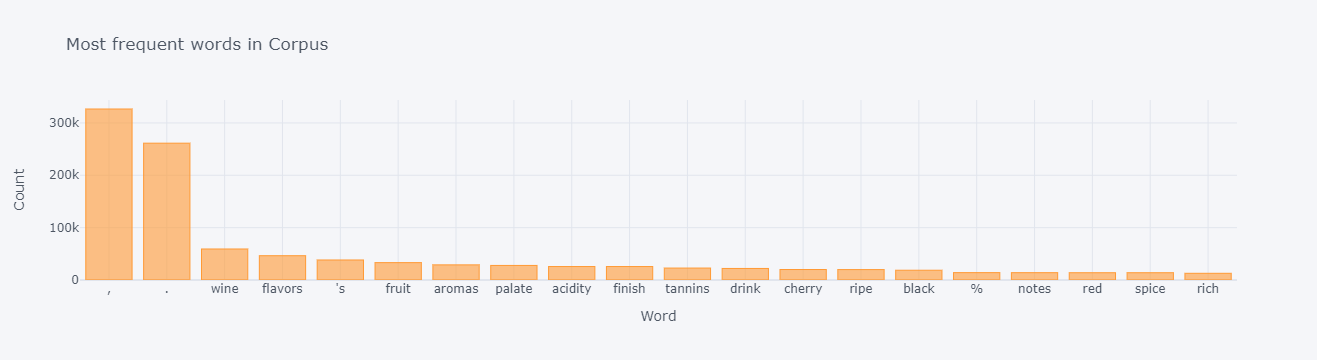

In [65]:
words_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

In [66]:
print("Total of {} words, {} unique words".format(len(all_words), len(words_df)))

Total of 3048144 words, 41274 unique words


In [67]:
print ("Using words with 4 or more appearances will reduce the corpus size to: {}".format(sum(words_df.wordCount >= 4)))

Using words with 4 or more appearances will reduce the corpus size to: 13983


In [68]:
words_df = words_df[words_df.wordCount >= 4]

#### Bag of words (One-hot-encoding) for Train and Test

In [69]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [70]:
clean_vocab = set(words_df.word)

In [71]:
count_vect = CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)

In [72]:
clean_bow_counts_train = count_vect.fit_transform(train_data.desc_low)
clean_bow_counts_test = count_vect.fit_transform(test_data.desc_low)

<h3>Define <b style = "color:green">clean_bow_counts_train</b> for <b style = "color:red">train</b> with description , and <b style = "color:green">clean_bow_counts_test</b> for <b style = "color:red">test</b> </h3>
<br>
<br>

### Regression

In [73]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge

#### Search for the best alpha on the Train set only :

In [74]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, clean_bow_counts_train, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

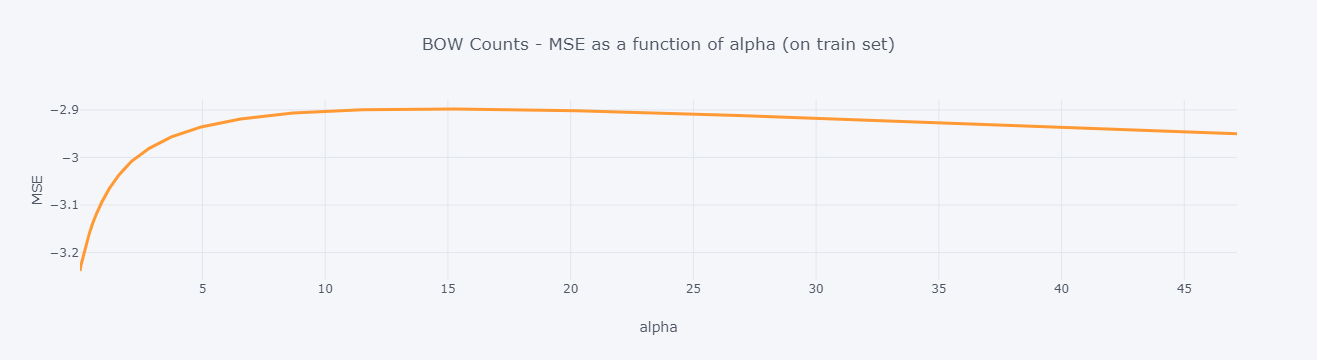

In [75]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [76]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

15.264179671752334 2.8981644549698355


#### Optimal Model : training the model with the best alpha, on the train set:

In [77]:
model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=15.264179671752334)

In [78]:
test_data['NLP_with_description_predicted_points'] = model.predict(clean_bow_counts_test)

In [79]:
NLP_with_description_predicted_points = calc_prediction_quality(test_data, 'NLP_with_description_predicted_points','points')
NLP_with_description_predicted_points

MSE    2.883265
MAE    1.334152
R2     0.698358
dtype: float64

In [105]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, NLP_with_description_predicted_points], index=['baseline_1', 'baseline_2','baseline_3', 'NLP_with_description_predicted_points'])
all_compared

,MSE,MAE,R2
baseline_1,9.559410,2.534726,-0.000087
baseline_2,9.052361,2.462888,0.052960
baseline_3,8.521883,2.373365,0.108457
NLP_with_description_predicted_points,2.883265,1.334152,0.698358


<div style="border:1px solid green; padding:15px;border-radius:25px">
<br>
<h3>The result of NLP_with_description_predicted_points </h3>
<h5>MSE: 2.883265 </h5>
<h5>MAE: 1.334152 </h5>
<h5>R2:  0.698358</h5>
<br>
    </div>

# Using both the text and other features

#### Using both the text and other features (encoded in the Boosting trees part)

In [81]:
features

['country',
 'province',
 'region_1',
 'region_2',
 'taster_name',
 'variety',
 'winery',
 'price']

In [82]:
from scipy.sparse import coo_matrix, hstack
from sklearn.preprocessing import StandardScaler

### using scale and standard for make all features in same scale

In [83]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_encoded_features.values)
scaled_train_df = pd.DataFrame(scaled_train, index=train_encoded_features.index, columns=train_encoded_features.columns)
scaled_test = scaler.transform(test_encoded_features.values)
scaled_test_df = pd.DataFrame(scaled_test, index=test_encoded_features.index, columns=test_encoded_features.columns)

### make train_united_features that combain description column with other features , same as with test

In [84]:
train_features_spares_matrix = coo_matrix(scaled_train_df[features])
train_united_features = hstack((clean_bow_counts_train ,train_features_spares_matrix))

test_features_spares_matrix = coo_matrix(scaled_test_df[features])
test_united_features = hstack((clean_bow_counts_test ,test_features_spares_matrix))

In [85]:
train_features_spares_matrix.shape

(95990, 8)

#### Search for the best alpha on the Train set only :

In [86]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, train_united_features, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

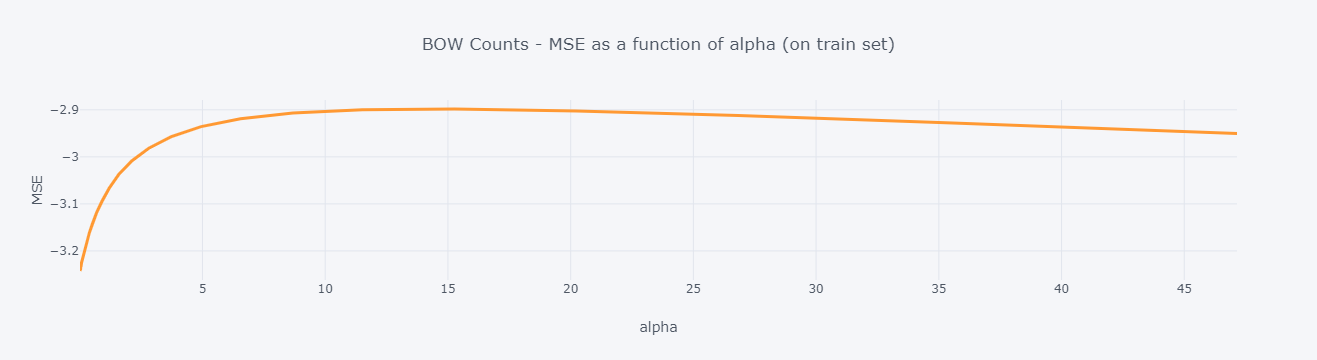

In [87]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [88]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

15.264179671752334 2.89830211987311


#### Optimal Model : training the model with the best alpha, on the train set:

In [89]:
model = Ridge(alpha=opt_alpha)
model.fit(train_united_features, train_data.points)

Ridge(alpha=15.264179671752334)

In [90]:
test_data['NLP_with_all_features_predicted_points'] = model.predict(test_united_features)

In [106]:
NLP_with_all_features_predicted_points = calc_prediction_quality(test_data, 'NLP_with_all_features_predicted_points','points')
NLP_with_all_features_predicted_points

MSE    2.882593
MAE    1.334042
R2     0.698429
dtype: float64

In [107]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, NLP_with_description_predicted_points, NLP_with_all_features_predicted_points], index=['baseline_1', 'baseline_2','baseline_3', 'NLP_with_description_predicted_points', 'NLP_with_all_features_predicted_points'])
all_compared

,MSE,MAE,R2
baseline_1,9.559410,2.534726,-0.000087
baseline_2,9.052361,2.462888,0.052960
baseline_3,8.521883,2.373365,0.108457
NLP_with_description_predicted_points,2.883265,1.334152,0.698358
NLP_with_all_features_predicted_points,2.882593,1.334042,0.698429


<div style="border:1px solid green; padding:15px;border-radius:25px">
<br>
<h3>The result of NLP_with_all_features_predicted_points </h3>
<h5>MSE: 2.882593 </h5>
<h5>MAE: 1.334042 </h5>
<h5>R2: 0.698429</h5>
<h5>Here we can see that the result a <b style="color:green">little bit better</b> than the model with description column only</h5>
<br>
    </div>

# Classical NLP without outliers

country           AxesSubplot(0.125,0.657941;0.227941x0.222059)
province       AxesSubplot(0.398529,0.657941;0.227941x0.222059)
region_1       AxesSubplot(0.672059,0.657941;0.227941x0.222059)
region_2          AxesSubplot(0.125,0.391471;0.227941x0.222059)
taster_name    AxesSubplot(0.398529,0.391471;0.227941x0.222059)
variety        AxesSubplot(0.672059,0.391471;0.227941x0.222059)
winery               AxesSubplot(0.125,0.125;0.227941x0.222059)
price             AxesSubplot(0.398529,0.125;0.227941x0.222059)
points            AxesSubplot(0.672059,0.125;0.227941x0.222059)
dtype: object

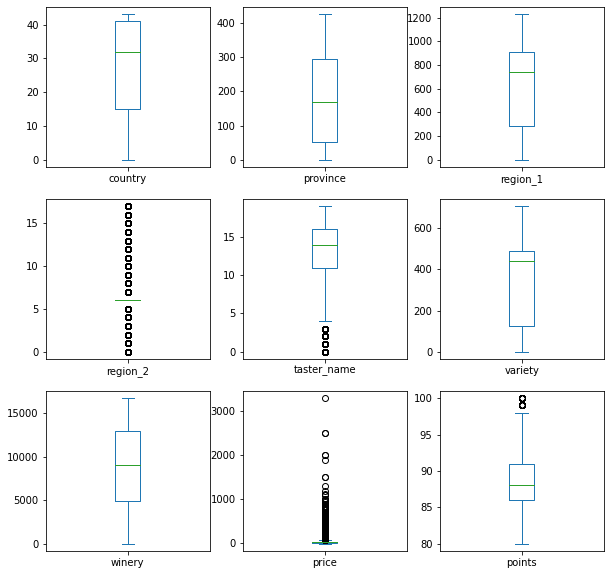

In [92]:
train_encoded_features.plot(kind='box', subplots=True, figsize=(10,10), layout=(3,3))

In [93]:
selected_features = ['country',
 'province',
 'region_1',
 'region_2',
 'taster_name',
 'variety',
 'winery']

import numpy as np
from scipy import stats
train_encoded_features[(np.abs(stats.zscore(train_encoded_features)) < 3).all(axis=1)]


In [94]:
encoded_features2 = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features2['points'] = wine_reviews.points
encoded_features2.head()

,country,province,region_1,region_2,taster_name,variety,winery,points
0,22,332,424,6,9,691,11608,87
1,32,108,738,6,16,451,12956,87
2,41,269,1218,17,15,437,13018,87
3,41,218,549,6,0,480,14390,87
4,41,269,1218,17,15,441,14621,87


In [95]:
encoded_features2.shape

(119988, 8)

In [96]:
train_encoded_features2 = encoded_features2[encoded_features2.index.isin(train_data.index)]
test_encoded_features2 = encoded_features2[encoded_features2.index.isin(test_data.index)]
assert(len(train_encoded_features2) + len(test_encoded_features2) == len(wine_reviews))

In [97]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_encoded_features2.values)
scaled_train_df = pd.DataFrame(scaled_train, index=train_encoded_features2.index, columns=train_encoded_features2.columns)
scaled_test = scaler.transform(test_encoded_features2.values)
scaled_test_df = pd.DataFrame(scaled_test, index=test_encoded_features2.index, columns=test_encoded_features2.columns)

In [98]:
train_features_spares_matrix2 = coo_matrix(scaled_train_df[selected_features])
train_united_features2 = hstack((clean_bow_counts_train ,train_features_spares_matrix2))

test_features_spares_matrix2 = coo_matrix(scaled_test_df[selected_features])
test_united_features2 = hstack((clean_bow_counts_test ,test_features_spares_matrix2))

In [99]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, train_united_features2, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

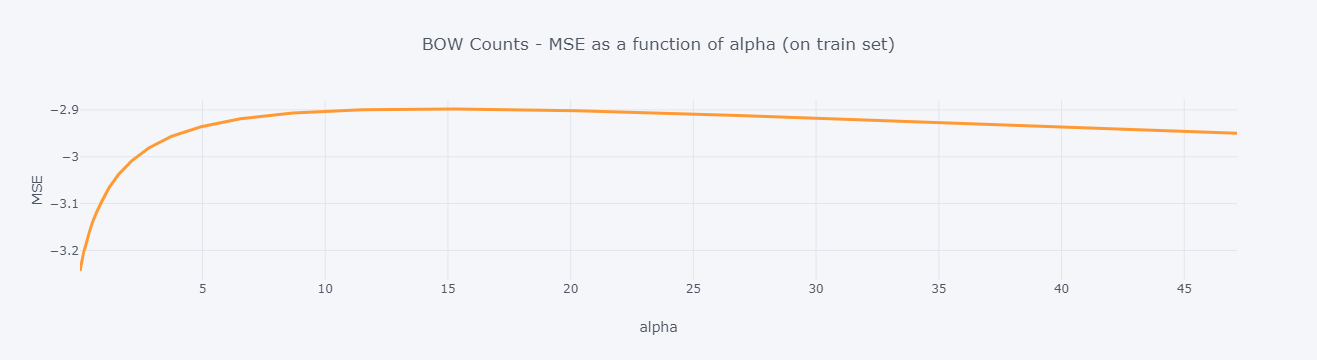

In [100]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [101]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

15.264179671752334 2.898247168021745


In [102]:
model = Ridge(alpha=opt_alpha)
model.fit(train_united_features2, train_data.points)

Ridge(alpha=15.264179671752334)

In [103]:
test_data['NLP_with_all_features_without_outliers'] = model.predict(test_united_features2)

In [108]:
NLP_with_all_features_without_outliers = calc_prediction_quality(test_data, 'NLP_with_all_features_without_outliers','points')
NLP_with_all_features_without_outliers

MSE    2.882455
MAE    1.334047
R2     0.698443
dtype: float64

In [109]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, NLP_with_description_predicted_points, NLP_with_all_features_predicted_points,NLP_with_all_features_without_outliers], index=['baseline_1', 'baseline_2','baseline_3', 'NLP_with_description_predicted_points', 'NLP_with_all_features_predicted_points','NLP_with_all_features_without_outliers'])
all_compared

,MSE,MAE,R2
baseline_1,9.559410,2.534726,-0.000087
baseline_2,9.052361,2.462888,0.052960
baseline_3,8.521883,2.373365,0.108457
NLP_with_description_predicted_points,2.883265,1.334152,0.698358
NLP_with_all_features_predicted_points,2.882593,1.334042,0.698429
NLP_with_all_features_without_outliers,2.882455,1.334047,0.698443


<div style="border:1px solid green; padding:15px;border-radius:25px">
<br>
<h3>The result of NLP_with_all_features_without_outliers </h3>
<h5>MSE: 2.882455 </h5>
<h5>MAE: 1.334047 </h5>
<h5>R2: 0.698443</h5>
<h5>Here we can see that the result a <b style="color:green">little bit better</b> than the model with all features</h5>
<br>
    </div>

# Tokenization for prepare to DNN models

In [110]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

What is a good size for the vocabulary? 

In [111]:
wine_reviews.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    60.0
0.99    72.0
Name: description, dtype: float64

In [112]:
vocab_size = 32000
sequence_length = 60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

In [113]:
vectorize_layer.adapt(train_data['description'])

In [114]:
sample_description = train_data['description'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

This is made from estate-grown fruit in Jamieson Canyon, on the extreme southern end of the valley. Delicate in style with a soft and silky texture, it imparts rhubarb and cranberry accents around a core of rose flavor.


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([   7,    8,   99,   22, 1342,   16,   10,    1, 2753,   15,    3,
       1508,  911,  305,    5,    3,  359,  261,   10,  132,    6,    4,
         46,    2,  252,   54,   12, 2302,  850,    2,  239,  408,  400,
          4,  205,    5,  302,  112,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int64)>

In [115]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

7 --->  this
8 --->  is
99 --->  made
22 --->  from
1342 --->  estategrown
16 --->  fruit
10 --->  in
1 --->  [UNK]
2753 --->  canyon
15 --->  on
3 --->  the
1508 --->  extreme
911 --->  southern
305 --->  end
5 --->  of
3 --->  the
359 --->  valley
261 --->  delicate
10 --->  in
132 --->  style


# DNN with description only by average technique

#### Modeling

In [116]:
embedding_dim=16

dnn_model_with_average = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [117]:
dnn_model_with_average.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 hidden_layer (Dense)        (None, 164)               2788      
                                                                 
 dropout (Dropout)           (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 1

In [118]:
tf.keras.utils.plot_model(dnn_model_with_average, show_dtype=False, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [119]:
dnn_model_with_average.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=['mean_squared_error','mean_absolute_error'])

In [120]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = dnn_model_with_average.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 7s 9ms/step - loss: 21.9015 - mean_squared_error: 1352.5582 - mean_absolute_error: 21.9015 - val_loss: 2.4598 - val_mean_squared_error: 9.1427 - val_mean_absolute_error: 2.4598
Epoch 2/20
750/750 [==============================] - 6s 8ms/step - loss: 3.4509 - mean_squared_error: 18.7184 - mean_absolute_error: 3.4509 - val_loss: 1.7020 - val_mean_squared_error: 4.5872 - val_mean_absolute_error: 1.7020
Epoch 3/20
750/750 [==============================] - 6s 8ms/step - loss: 3.1703 - mean_squared_error: 15.8679 - mean_absolute_error: 3.1703 - val_loss: 1.5070 - val_mean_squared_error: 3.6360 - val_mean_absolute_error: 1.5070
Epoch 4/20
750/750 [==============================] - 6s 8ms/step - loss: 3.0920 - mean_squared_error: 15.0697 - mean_absolute_error: 3.0920 - val_loss: 1.4845 - val_mean_squared_error: 3.5565 - val_mean_absolute_error: 1.4845
Epoch 5/20
750/750 [==============================] - 6s 8ms/step - loss: 3.0858 - mean_

### Simple NN Prediction & Evaluation

In [121]:
test_data['dnn_prediction'] = dnn_model_with_average.predict(test_data[text_col])

750/750 [==============================] - 1s 1ms/step


In [122]:
dnn_stats = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
dnn_stats

MSE    2.940726
MAE    1.347394
R2     0.692347
dtype: float64

In [123]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, NLP_with_description_predicted_points, NLP_with_all_features_predicted_points,NLP_with_all_features_without_outliers,dnn_stats], index=['baseline_1', 'baseline_2','baseline_3', 'NLP_with_description_predicted_points', 'NLP_with_all_features_predicted_points','NLP_with_all_features_without_outliers','dnn_prediction'])
all_compared

,MSE,MAE,R2
baseline_1,9.559410,2.534726,-0.000087
baseline_2,9.052361,2.462888,0.052960
baseline_3,8.521883,2.373365,0.108457
NLP_with_description_predicted_points,2.883265,1.334152,0.698358
NLP_with_all_features_predicted_points,2.882593,1.334042,0.698429
NLP_with_all_features_without_outliers,2.882455,1.334047,0.698443
dnn_prediction,2.940726,1.347394,0.692347


<div style="border:1px solid yellow; padding:15px;border-radius:25px">
<br>
<h5>By using Dense(units = 164) we accapt a lot nerouns that can help us for a lot words. and with the Droupout(0.2) we do littel regularization on the model to prevet overfitting </h5>

<h3>The result of dnn_prediction </h3>
<h5>MSE: 2.940726 </h5>
<h5>MAE: 1.347394 </h5>
<h5>R2: 0.692347</h5>
<h5>Here we can see that the result a <b style="color:red">little bit worse</b> than the model that used with NLP</h5>
<br>
    </div>

# Descriptions words concatinated

In [124]:
from tensorflow.keras.layers import Reshape, Dense, Dropout
from tensorflow.keras import Sequential

In [125]:
embedding_dim=16

dnn_model_with_concatinated = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(768, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [126]:
dnn_model_with_concatinated.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 concat_words (Reshape)      (None, 960)               0         
                                                                 
 hidden_layer (Dense)        (None, 768)               738048    
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 769       
                                                      

In [127]:
dnn_model_with_concatinated.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [128]:
tf.keras.utils.plot_model(dnn_model_with_concatinated, show_dtype=True, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [129]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = dnn_model_with_concatinated.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 11s 15ms/step - loss: 6.4916 - mean_squared_error: 273.5556 - mean_absolute_error: 6.4916 - val_loss: 1.8093 - val_mean_squared_error: 5.1936 - val_mean_absolute_error: 1.8093
Epoch 2/20
750/750 [==============================] - 11s 15ms/step - loss: 1.9964 - mean_squared_error: 6.3090 - mean_absolute_error: 1.9964 - val_loss: 1.4337 - val_mean_squared_error: 3.3257 - val_mean_absolute_error: 1.4337
Epoch 3/20
750/750 [==============================] - 11s 15ms/step - loss: 1.8639 - mean_squared_error: 5.4999 - mean_absolute_error: 1.8639 - val_loss: 1.3733 - val_mean_squared_error: 3.0422 - val_mean_absolute_error: 1.3733
Epoch 4/20
750/750 [==============================] - 11s 15ms/step - loss: 1.8172 - mean_squared_error: 5.2223 - mean_absolute_error: 1.8172 - val_loss: 1.3322 - val_mean_squared_error: 2.8848 - val_mean_absolute_error: 1.3322
Epoch 5/20
750/750 [==============================] - 11s 14ms/step - loss: 1.7795 - m

In [130]:
test_data['dnn_prediction_with_concatinated'] = dnn_model_with_concatinated.predict(test_data[text_col])

750/750 [==============================] - 2s 2ms/step


In [131]:
dnn_prediction_with_concatinated = calc_prediction_quality(test_data, 'dnn_prediction_with_concatinated', target_col)
dnn_prediction_with_concatinated

MSE    2.883638
MAE    1.330997
R2     0.698319
dtype: float64

In [132]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, NLP_with_description_predicted_points, NLP_with_all_features_predicted_points,NLP_with_all_features_without_outliers,dnn_stats,dnn_prediction_with_concatinated], index=['baseline_1', 'baseline_2','baseline_3', 'NLP_with_description_predicted_points', 'NLP_with_all_features_predicted_points','NLP_with_all_features_without_outliers','dnn_prediction','dnn_prediction_with_concatinated'])
all_compared

,MSE,MAE,R2
baseline_1,9.559410,2.534726,-0.000087
baseline_2,9.052361,2.462888,0.052960
baseline_3,8.521883,2.373365,0.108457
NLP_with_description_predicted_points,2.883265,1.334152,0.698358
NLP_with_all_features_predicted_points,2.882593,1.334042,0.698429
NLP_with_all_features_without_outliers,2.882455,1.334047,0.698443
dnn_prediction,2.940726,1.347394,0.692347
dnn_prediction_with_concatinated,2.883638,1.330997,0.698319


<div style="border:1px solid yellow; padding:15px;border-radius:25px;">
<br>
<h5>By using Dense(units = 768) for able to accept a lot of information cause the concatization, and with the Droupout(0.2) we do littel regularization on the model to prevet overfitting </h5>

<h3>The result of dnn_prediction_with_concatinated </h3>
<h5>MSE: 2.883638 </h5>
<h5>MAE: 1.330997 </h5>
<h5>R2: 0.698319</h5>
<h5>Here we can see that the result a <b style="color:green">little bit better</b> than the DNN model that used with average technique, and still<b style="color:red"> worse</b> than NLP models</h5>
<br>
    </div>

# LSTM

In [133]:
vocab_size = 32000
sequence_length = 60

vectorize_layer_for_lstm = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

vectorize_layer_for_lstm.adapt(train_data['description'])

#### Modeling

In [134]:
from keras.layers import LSTM,Bidirectional
embedding_dim=16

lstm_nodel = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer_for_lstm,
    Embedding(vocab_size, embedding_dim , input_length = sequence_length , name="embedding"),
    LSTM(32,activation="tanh",name='lstm_hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

lstm_nodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 lstm_hidden_layer (LSTM)    (None, 32)                6272      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 518,305
Trainable params: 518,305
Non-trainable params: 0
________________________________________________

In [135]:
lstm_nodel.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=['mean_squared_error','mean_absolute_error'])

In [136]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = lstm_nodel.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=32,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
3000/3000 [==============================] - 53s 17ms/step - loss: 35.1483 - mean_squared_error: 1896.9651 - mean_absolute_error: 35.1483 - val_loss: 2.6756 - val_mean_squared_error: 11.1491 - val_mean_absolute_error: 2.6756
Epoch 2/20
3000/3000 [==============================] - 50s 17ms/step - loss: 6.5151 - mean_squared_error: 66.8581 - mean_absolute_error: 6.5151 - val_loss: 2.5316 - val_mean_squared_error: 9.8003 - val_mean_absolute_error: 2.5316
Epoch 3/20
3000/3000 [==============================] - 53s 18ms/step - loss: 6.4174 - mean_squared_error: 65.0206 - mean_absolute_error: 6.4174 - val_loss: 2.0659 - val_mean_squared_error: 6.6848 - val_mean_absolute_error: 2.0659
Epoch 4/20
3000/3000 [==============================] - 50s 17ms/step - loss: 6.2120 - mean_squared_error: 61.3417 - mean_absolute_error: 6.2120 - val_loss: 2.0224 - val_mean_squared_error: 6.4608 - val_mean_absolute_error: 2.0224
Epoch 5/20
3000/3000 [==============================] - 51s 17ms/step -

In [137]:
test_data['dnn3_lstm_prediction'] = lstm_nodel.predict(test_data[text_col])

750/750 [==============================] - 4s 5ms/step


In [138]:
dnn3_lstm_prediction = calc_prediction_quality(test_data, 'dnn3_lstm_prediction', target_col)
dnn3_lstm_prediction

MSE    3.433855
MAE    1.458351
R2     0.640757
dtype: float64

In [139]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, NLP_with_description_predicted_points, NLP_with_all_features_predicted_points,NLP_with_all_features_without_outliers,dnn_stats,dnn_prediction_with_concatinated,dnn3_lstm_prediction], index=['baseline_1', 'baseline_2','baseline_3', 'NLP_with_description_predicted_points', 'NLP_with_all_features_predicted_points','NLP_with_all_features_without_outliers','dnn_prediction','dnn_prediction_with_concatinated','dnn3_lstm_prediction'])
all_compared

,MSE,MAE,R2
baseline_1,9.559410,2.534726,-0.000087
baseline_2,9.052361,2.462888,0.052960
baseline_3,8.521883,2.373365,0.108457
NLP_with_description_predicted_points,2.883265,1.334152,0.698358
NLP_with_all_features_predicted_points,2.882593,1.334042,0.698429
NLP_with_all_features_without_outliers,2.882455,1.334047,0.698443
dnn_prediction,2.940726,1.347394,0.692347
dnn_prediction_with_concatinated,2.883638,1.330997,0.698319
dnn3_lstm_prediction,3.433855,1.458351,0.640757


<div style="border:1px solid yellow; padding:15px;border-radius:25px;">
<br>
<h5>By using LSTM(units = 32) using a littel neornes for pull down complexity of the calculation, and with the Droupout(0.2) we do littel regularization on the model to prevet overfitting , and pull down the batch size to 32 to make more iterations on the data for get better results </h5>

<h3>The result of dnn3_lstm_prediction </h3>
<h5>MSE: 3.433855 </h5>
<h5>MAE: 1.458351 </h5>
<h5>R2: 0.640757</h5>
<h5>Here we can see that the result a <b style="color:red">little bit worse</b> than the simple DNN models , and still<b style="color:red"> worse</b> than NLP models</h5>
<br>
    </div>

# Using external embedding (description feature only)

In [140]:
import os
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras

path_to_glove_file = "D:/Users/1/Desktop/DS-Thechnion/Python_ML-2022/Final project/data/glove.6B.100d.txt"

In [141]:
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [240]:
num_tokens = len(vectorize_layer.get_vocabulary()) + 2
word_index = dict(zip(vectorize_layer.get_vocabulary(), range(len(vectorize_layer.get_vocabulary()))))

embedding_dim = 100
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [268]:
external_embedding_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(num_tokens,embedding_dim, embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix), name="embedding" , trainable=False),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [260]:
external_embedding_model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 100)           3200200   
                                                                 
 global_average_pooling1d_13  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 hidden_layer (Dense)        (None, 264)               26664     
                                                                 
 dropout_26 (Dropout)        (None, 264)               0         
                                                                 
 output_layer (Dense)        (None, 1)               

In [261]:
external_embedding_model.compile(optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [262]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = external_embedding_model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 5s 7ms/step - loss: 15.0268 - mean_squared_error: 762.0690 - mean_absolute_error: 15.0268 - val_loss: 2.3714 - val_mean_squared_error: 8.9729 - val_mean_absolute_error: 2.3714
Epoch 2/20
750/750 [==============================] - 5s 6ms/step - loss: 3.1938 - mean_squared_error: 16.3415 - mean_absolute_error: 3.1938 - val_loss: 2.3297 - val_mean_squared_error: 8.3743 - val_mean_absolute_error: 2.3297
Epoch 3/20
750/750 [==============================] - 5s 6ms/step - loss: 3.1663 - mean_squared_error: 15.9013 - mean_absolute_error: 3.1663 - val_loss: 2.3076 - val_mean_squared_error: 8.1308 - val_mean_absolute_error: 2.3076
Epoch 4/20
750/750 [==============================] - 5s 6ms/step - loss: 3.0855 - mean_squared_error: 15.0775 - mean_absolute_error: 3.0855 - val_loss: 2.0495 - val_mean_squared_error: 6.5449 - val_mean_absolute_error: 2.0495
Epoch 5/20
750/750 [==============================] - 5s 6ms/step - loss: 2.9375 - mean_s

In [263]:
test_data['External_Embedding'] = external_embedding_model.predict(test_data[text_col])

750/750 [==============================] - 1s 1ms/step


In [269]:
External_Embedding = calc_prediction_quality(test_data, 'External_Embedding', target_col)
External_Embedding

MSE    4.957400
MAE    1.768601
R2     0.481366
dtype: float64

In [270]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, NLP_with_description_predicted_points, NLP_with_all_features_predicted_points,NLP_with_all_features_without_outliers,dnn_stats,dnn_prediction_with_concatinated,dnn3_lstm_prediction,External_Embedding], index=['baseline_1', 'baseline_2','baseline_3', 'NLP_with_description_predicted_points', 'NLP_with_all_features_predicted_points','NLP_with_all_features_without_outliers','dnn_prediction','dnn_prediction_with_concatinated','dnn3_lstm_prediction','External_Embedding'])
all_compared

,MSE,MAE,R2
baseline_1,9.559410,2.534726,-0.000087
baseline_2,9.052361,2.462888,0.052960
baseline_3,8.521883,2.373365,0.108457
NLP_with_description_predicted_points,2.883265,1.334152,0.698358
NLP_with_all_features_predicted_points,2.882593,1.334042,0.698429
NLP_with_all_features_without_outliers,2.882455,1.334047,0.698443
dnn_prediction,2.940726,1.347394,0.692347
dnn_prediction_with_concatinated,2.883638,1.330997,0.698319
dnn3_lstm_prediction,3.433855,1.458351,0.640757
External_Embedding,4.957400,1.768601,0.481366


<div style="border:1px solid yellow; padding:15px;border-radius:25px;">
<h3>The result of dnn3_lstm_prediction </h3>
<h5>MSE: 4.957400 </h5>
<h5>MAE: 1.768601 </h5>
<h5>R2: 0.4813667</h5>
<h5>Here we can see that the result a <b style="color:red">little bit worse</b> than the simple DNN models and LSTM , and still<b style="color:red"> worse</b> than NLP models</h5>
<br>
</div>